In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
import sys
sys.path.append('..')

In [2]:
test_indices = np.load('model_outputs/terra_test_indices.pkl', allow_pickle=True)
test_indices

array([ 75515,  75833,  84202, ...,  95939, 117952,  43567])

In [3]:
terra_modis_estimate = pd.read_pickle(f"data/DEEP_terra_transformed_modd_targets.pkl")
terra_modis_estimate.describe()

,mTau470,mTau550,mTau660
count,138681.000000,138681.000000,138681.000000
mean,-0.000001,-0.000004,-0.000001
std,0.999967,0.999993,0.999988
min,-2.874970,-2.892836,-2.861762
25%,-0.677970,-0.690577,-0.705030
50%,0.047335,0.039305,0.020363
75%,0.676271,0.703170,0.721741
max,3.472649,3.557837,3.582049


In [4]:
terra_y_test = pd.read_pickle('model_outputs/terra_y_test.pkl')
terra_y_test.describe()

,aTau470,aTau550,aTau660
count,13869.000000,13869.000000,13869.000000
mean,0.001488,0.001362,0.000903
std,1.001260,0.999635,0.998972
min,-3.861571,-3.743583,-4.248508
25%,-0.666602,-0.669578,-0.653554
50%,0.003239,-0.010510,-0.012460
75%,0.677776,0.674194,0.660570
max,4.003292,4.017426,3.991789


In [5]:
terra_mlp_out = pd.read_pickle('model_outputs/terra_mlp_out.pkl')
terra_mlp_out.describe()

,aTau470,aTau550,aTau660
count,13869.000000,13869.000000,13869.000000
mean,-0.009064,-0.007984,-0.007236
std,0.886511,0.884863,0.879352
min,-3.669776,-3.659425,-3.614957
25%,-0.625231,-0.622712,-0.621268
50%,-0.081165,-0.078130,-0.080925
75%,0.561613,0.565090,0.563219
max,4.196873,4.204558,4.189821


In [6]:
terra_edl_out_np = np.load('model_outputs/terra_edl_out_edl_param=0.1.npy')
terra_mu, terra_v, terra_alpha, terra_beta = tf.split(terra_edl_out_np, [terra_mlp_out.shape[1] for i in range(4)], axis=-1)
terra_var = np.sqrt(terra_beta / (terra_v * (terra_alpha - 1)))
terra_edl_out = pd.DataFrame(terra_mu.numpy(), columns=terra_mlp_out.columns)

2022-03-08 00:01:20.984619: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
from kde import calc_kde2d
from aod_models import plot_kde2d, plot_linregress, plot_linregress_diff

Starting the 2D kernel density estimation with 13869 data points...
Evaluating 2D kernel on grid with (Nx,Ny)=(256,256) ...
X, Y, P shapes:  (256, 256) (256, 256) (256, 256)


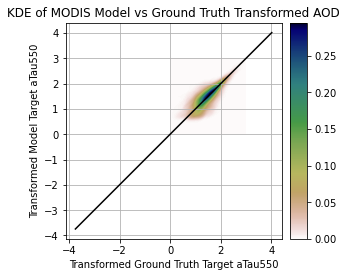

In [8]:
transformed_y_test = terra_y_test.aTau550
transformed_modis_y_test_aod = terra_modis_estimate.iloc[test_indices].mTau550
y_test_bins, out_bins_modis, P_modis = calc_kde2d(transformed_y_test, transformed_modis_y_test_aod)
plot_kde2d(y_test_bins, out_bins_modis, P_modis, x_bounds=[0,3], y_bounds=[0,3], Title='KDE of MODIS Model vs Ground Truth Transformed AOD', xLabel='Transformed Ground Truth Target aTau550', yLabel='Transformed Model Target aTau550')

Starting the 2D kernel density estimation with 13869 data points...
Evaluating 2D kernel on grid with (Nx,Ny)=(256,256) ...
X, Y, P shapes:  (256, 256) (256, 256) (256, 256)


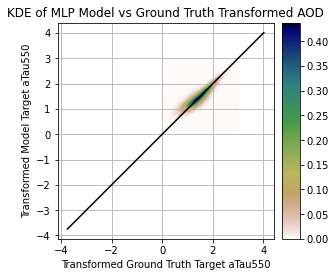

In [9]:
transformed_y_test = terra_y_test.aTau550
transformed_out_df = terra_mlp_out.aTau550
y_test_bins, out_bins, P = calc_kde2d(transformed_y_test, transformed_out_df)
plot_kde2d(y_test_bins, out_bins, P, Title='KDE of MLP Model vs Ground Truth Transformed AOD', xLabel='Transformed Ground Truth Target aTau550', yLabel='Transformed Model Target aTau550')

Starting the 2D kernel density estimation with 13869 data points...
Evaluating 2D kernel on grid with (Nx,Ny)=(256,256) ...
X, Y, P shapes:  (256, 256) (256, 256) (256, 256)


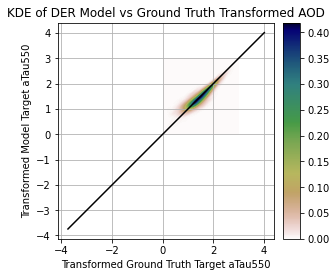

In [10]:
transformed_y_test = terra_y_test.aTau550
transformed_out_edl_df = terra_edl_out.aTau550
y_test_bins, out_edl_bins, P_edl = calc_kde2d(transformed_y_test, transformed_out_edl_df)
plot_kde2d(y_test_bins, out_edl_bins, P_edl, Title='KDE of DER Model vs Ground Truth Transformed AOD', xLabel='Transformed Ground Truth Target aTau550', yLabel='Transformed Model Target aTau550')

0.7689715379788619 0.0036169502580242225 0.7671644952142888 0.0 0.005460012087971192
0.7671644952142888


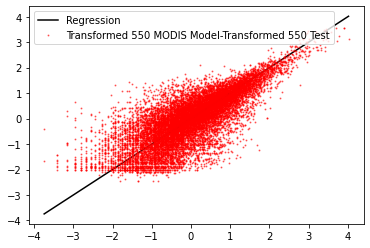

In [11]:
# MODIS lin reg
r = plot_linregress(transformed_y_test, transformed_modis_y_test_aod, np.linspace(transformed_y_test.min(), transformed_y_test.max()), 'Transformed 550 MODIS Model-Transformed 550 Test')
print(r)

0.7874937089182291 -0.009056153276086405 0.8896310282531995 0.0 0.003432874428154108
0.8896310282531995


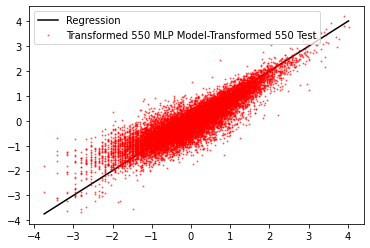

In [12]:
# MLP lin reg
r = plot_linregress(transformed_y_test, transformed_out_df, np.linspace(transformed_y_test.min(), transformed_y_test.max()), 'Transformed 550 MLP Model-Transformed 550 Test')
print(r)

0.7710951694599862 -0.014894511032721275 0.8826855626407437 0.0 0.0034863848734746467
0.8826855626407437


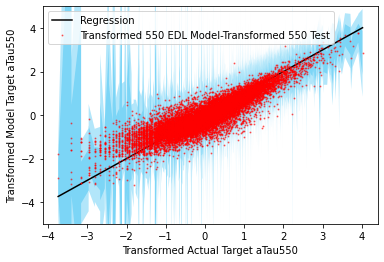

In [13]:
# EDL lin reg
n_stds = 4
std = np.minimum(np.sqrt(terra_var), 1e3)
r = plot_linregress(transformed_y_test, transformed_out_edl_df, np.linspace(transformed_y_test.min(), transformed_y_test.max()), 'Transformed 550 EDL Model-Transformed 550 Test')
indices = np.argsort(transformed_y_test)
plt.fill_between(
    transformed_y_test[indices], (transformed_out_edl_df[indices] - std[indices][:,1]), (transformed_out_edl_df[indices] + std[indices][:,1]),
    alpha=0.3,
    edgecolor=None,
    facecolor='#00aeef',
    linewidth=0,
    zorder=1)
plt.fill_between(
    transformed_y_test[indices], (transformed_out_edl_df[indices] - 2*std[indices][:,1]), (transformed_out_edl_df[indices] + 2*std[indices][:,1]),
    alpha=0.3,
    edgecolor=None,
    facecolor='#00aeef',
    linewidth=0,
    zorder=1)
plt.xlabel('Transformed Actual Target aTau550')
plt.ylabel('Transformed Model Target aTau550')
plt.ylim([-5,5])
print(r)

0.7710951694599862 -0.014894511032721275 0.8826855626407437 0.0 0.0034863848734746467
[ 1.2799126  -0.9652826   0.6750139  ...  0.03667952 -0.90608555
 -0.6785816 ]
0.8826855626407437


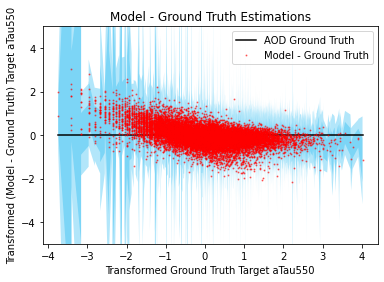

In [14]:
n_stds = 4
std = np.minimum(np.sqrt(terra_var), 1e3)
r = plot_linregress_diff(transformed_y_test.values, transformed_out_edl_df.values, np.linspace(transformed_y_test.min(), transformed_y_test.max()))
indices = np.argsort(transformed_y_test)
plt.fill_between(
    transformed_y_test[indices], (transformed_out_edl_df[indices] - std[indices][:,1] - transformed_y_test[indices].values), (transformed_out_edl_df[indices] + std[indices][:,1] - transformed_y_test[indices].values),
    alpha=0.3,
    edgecolor=None,
    facecolor='#00aeef',
    linewidth=0,
    zorder=1)
plt.fill_between(
    transformed_y_test[indices], (transformed_out_edl_df[indices] - 2*std[indices][:,1] - transformed_y_test[indices].values), (transformed_out_edl_df[indices] + 2*std[indices][:,1] - transformed_y_test[indices].values),
    alpha=0.3,
    edgecolor=None,
    facecolor='#00aeef',
    linewidth=0,
    zorder=1)
plt.xlabel('Transformed Ground Truth Target aTau550')
plt.ylabel('Transformed (Model - Ground Truth) Target aTau550')
plt.legend(loc='best')
plt.ylim([-5,5])
print(r)

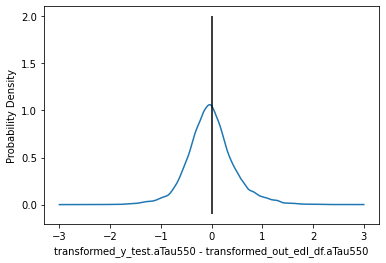

In [22]:
from sklearn.neighbors import KernelDensity
diff_transformed_aod_estimations = transformed_out_edl_df.to_numpy() - transformed_y_test.to_numpy()
kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(diff_transformed_aod_estimations[:, np.newaxis])
X_plot = np.linspace(-3, 3, 1000)[:, np.newaxis]
log_dens = kde.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens))
plt.xlabel('transformed_y_test.aTau550 - transformed_out_edl_df.aTau550')
plt.ylabel('Probability Density')
plt.vlines(0, ymin=-0.1, ymax=2, color='k')